In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import cv2
import os, glob
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [2]:
data_dir = (r"E:\final year projects\project 1\TK52353\TK52353\CODE\Plants")
train_dir = os.path.join(data_dir)
Plants = ['Calcium deficiency','Complete nutrition', 'Iron Deficiency', 'Magnesium Deficiencies', 'Nitrogen Deficiency', 'Potassium Deficiency']
print(Plants)

['Calcium deficiency', 'Complete nutrition', 'Iron Deficiency', 'Magnesium Deficiencies', 'Nitrogen Deficiency', 'Potassium Deficiency']


In [3]:
train_data = []
for defects_id, sp in enumerate(Plants):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'LabelID', 'Label'])
train.head()

,File,LabelID,Label
0,Calcium deficiency/Carence-calcium-1.jpg,0,Calcium deficiency
1,Calcium deficiency/dhgshg.jfif,0,Calcium deficiency
2,Calcium deficiency/fbhsd.jpg,0,Calcium deficiency
3,Calcium deficiency/gerg.jfif,0,Calcium deficiency
4,Calcium deficiency/gergre.jpg,0,Calcium deficiency


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train))  # Reset indices
train.tail()

,File,LabelID,Label
106,Potassium Deficiency/nfgfjj.png,5,Potassium Deficiency
107,Calcium deficiency/jyyj.jfif,0,Calcium deficiency
108,Potassium Deficiency/fhfhd.jfif,5,Potassium Deficiency
109,Magnesium Deficiencies/ffn.jfif,3,Magnesium Deficiencies
110,"Potassium Deficiency/khk,kg.jfif",5,Potassium Deficiency


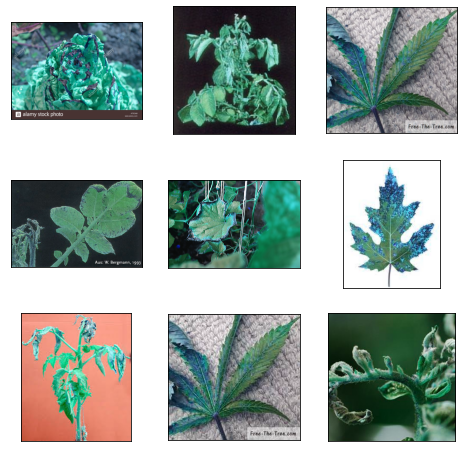

In [5]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Calcium deficiency', 3, 3)

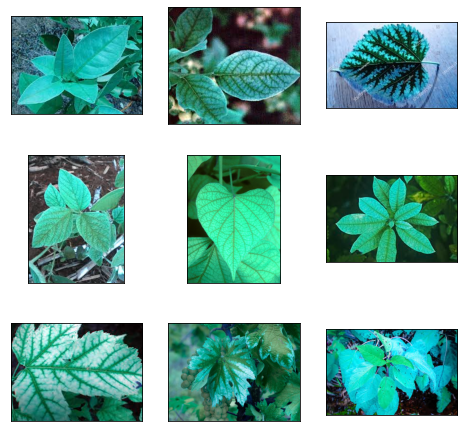

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8))
    defect_files = train['File'][train['Label'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('Iron Deficiency', 3, 3)

In [7]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    class_mode='categorical')

Found 42 images belonging to 6 classes.


In [8]:
IMAGE_SIZE = 128


def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))


def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)


x_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        x_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

111it [00:01, 66.00it/s]


In [9]:
x_train = x_train / 255.

num_classes=10
y_train = train['LabelID'].values
y_train = to_categorical(y_train,num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=SEED)
print('Train Shape: {}'.format(X_train.shape))

Train Shape: (77, 128, 128, 3)


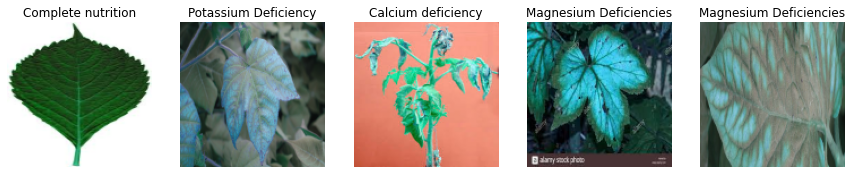

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(Plants[np.argmax(Y_train[i])])

In [11]:
from tensorflow import keras

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [128, 128,3]),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(10, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6291584   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 6,302,250
Trainable params: 6,302,250
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist=model.fit(X_train,Y_train,epochs=15,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/15
8/8 [==============================] - 1s 67ms/step - loss: 6.6952 - accuracy: 0.1688 - val_loss: 6.4140 - val_accuracy: 0.1471
Epoch 2/15
8/8 [==============================] - 0s 42ms/step - loss: 3.1399 - accuracy: 0.3896 - val_loss: 3.7746 - val_accuracy: 0.2941
Epoch 3/15
8/8 [==============================] - 0s 39ms/step - loss: 2.3010 - accuracy: 0.3636 - val_loss: 2.4399 - val_accuracy: 0.2353
Epoch 4/15
8/8 [==============================] - 0s 40ms/step - loss: 2.1216 - accuracy: 0.3506 - val_loss: 3.8831 - val_accuracy: 0.2059
Epoch 5/15
8/8 [==============================] - 0s 39ms/step - loss: 1.6049 - accuracy: 0.4935 - val_loss: 3.2753 - val_accuracy: 0.1176
Epoch 6/15
8/8 [==============================] - 0s 44ms/step - loss: 0.9889 - accuracy: 0.6753 - val_loss: 1.9717 - val_accuracy: 0.4118
Epoch 7/15
8/8 [==============================] - 0s 40ms/step - loss: 0.8041 - accuracy: 0.7662 - val_loss: 3.2999 - val_accuracy: 0.2941
Epoch 8/15
8/8 [===========

In [14]:
model.evaluate(X_test, Y_test)
model.save("D:\DL\Plant Nutrient\models\ANN.h5")

2/2 [==============================] - 0s 7ms/step - loss: 3.3195 - accuracy: 0.3529


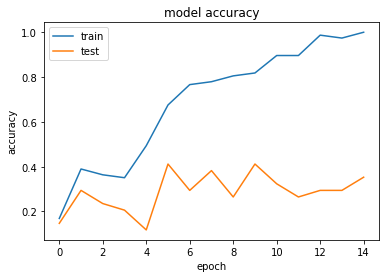

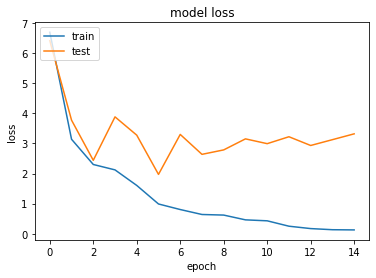

In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.save("D:\DL\Plant Nutrient\ANN_acc.png")


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.save("D:\DL\Plant Nutrient\ANN_acc.png")

In [16]:
model1 = Sequential()

model1.add(Conv2D(128, kernel_size=(3,3),activation='relu',input_shape=(128,128,3)))
model1.add(Conv2D(64, kernel_size=(3,3),activation='relu'))
model1.add(Conv2D(32, kernel_size=(3,3),activation='relu'))
model1.add(Flatten())
model1.add(Dense(10, activation='softmax'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 128)     3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 64)      73792     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 122, 122, 32)      18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 476288)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                4762890   
Total params: 4,858,730
Trainable params: 4,858,730
Non-trainable params: 0
_________________________________________________________________


In [17]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist1=model1.fit(X_train,Y_train,epochs=10,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/10
8/8 [==============================] - 13s 2s/step - loss: 3.8071 - accuracy: 0.1299 - val_loss: 1.8943 - val_accuracy: 0.2647
Epoch 2/10
8/8 [==============================] - 13s 1s/step - loss: 1.9225 - accuracy: 0.2208 - val_loss: 1.9933 - val_accuracy: 0.1765
Epoch 3/10
8/8 [==============================] - 9s 1s/step - loss: 1.6186 - accuracy: 0.3636 - val_loss: 2.2404 - val_accuracy: 0.0882
Epoch 4/10
8/8 [==============================] - 10s 1s/step - loss: 1.1644 - accuracy: 0.6234 - val_loss: 1.9825 - val_accuracy: 0.2647
Epoch 5/10
8/8 [==============================] - 10s 1s/step - loss: 0.7653 - accuracy: 0.8182 - val_loss: 1.9570 - val_accuracy: 0.3235
Epoch 6/10
8/8 [==============================] - 10s 1s/step - loss: 0.2777 - accuracy: 0.9610 - val_loss: 1.8453 - val_accuracy: 0.4412
Epoch 7/10
8/8 [==============================] - 9s 1s/step - loss: 0.1105 - accuracy: 0.9740 - val_loss: 1.8047 - val_accuracy: 0.3529
Epoch 8/10
8/8 [====================

In [18]:
model1.evaluate(X_test, Y_test)
model1.save("D:\DL\Plant Nutrient\models\CNN.h5")

2/2 [==============================] - 1s 46ms/step - loss: 3.9007 - accuracy: 0.2941


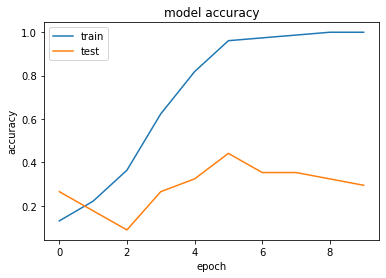

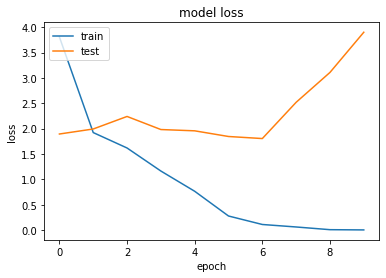

In [19]:
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.save("D:\DL\Plant Nutrient\CNN_acc.png")


plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.save("D:\DL\Plant Nutrient\CNN_loss.png")

In [20]:
import tensorflow as tf

In [21]:
base_model2 = tf.keras.applications.DenseNet121(input_shape=(128, 128, 3), include_top=False,
                          weights='imagenet')
model2 = Sequential()
model2.add(base_model2)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(10, activation='sigmoid'))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                65600     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 7,104,010
Trainable params: 7,020,234
Non-trainable params: 83,776
_______________________________________

In [22]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
hist2=model2.fit(X_train,Y_train,epochs=10,batch_size=10,validation_data=(X_test,Y_test))

Epoch 1/10
8/8 [==============================] - 24s 2s/step - loss: 2.7005 - accuracy: 0.1558 - val_loss: 5.3804 - val_accuracy: 0.2647
Epoch 2/10
8/8 [==============================] - 13s 2s/step - loss: 1.3432 - accuracy: 0.5974 - val_loss: 7.7468 - val_accuracy: 0.0294
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 1.2069 - accuracy: 0.6623 - val_loss: 138.4161 - val_accuracy: 0.0882
Epoch 4/10
8/8 [==============================] - 14s 2s/step - loss: 0.8211 - accuracy: 0.7792 - val_loss: 219.4259 - val_accuracy: 0.0588
Epoch 5/10
8/8 [==============================] - 13s 2s/step - loss: 0.7750 - accuracy: 0.8312 - val_loss: 362.3957 - val_accuracy: 0.0000e+00
Epoch 6/10
8/8 [==============================] - 14s 2s/step - loss: 0.5390 - accuracy: 0.8442 - val_loss: 18.3957 - val_accuracy: 0.1471
Epoch 7/10
8/8 [==============================] - 14s 2s/step - loss: 0.3803 - accuracy: 0.9481 - val_loss: 12.3391 - val_accuracy: 0.1471
Epoch 8/10
8/8 [======

In [23]:
model2.evaluate(X_test, Y_test)
model2.save("D:\DL\Plant Nutrient\models\DenseNet121.h5")

2/2 [==============================] - 1s 81ms/step - loss: 3.7992 - accuracy: 0.2647


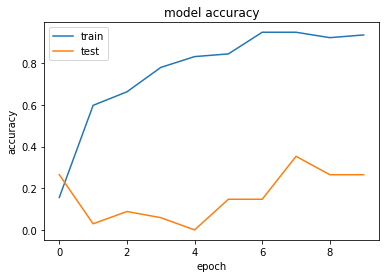

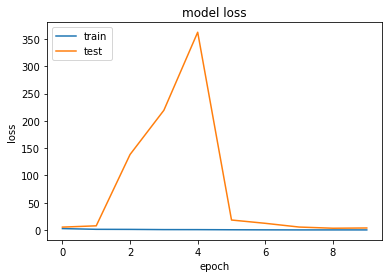

In [24]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.save("D:\DL\Plant Nutrient\DenseNet121_acc.png")


plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.save("D:\DL\Plant Nutrient\DenseNet121_loss.png")

In [25]:
Accuracy = []

for i in [hist, hist1, hist2]:
    x = i.history.get('accuracy')[-1]
    Accuracy.append(x)

Accuracy

[1.0, 1.0, 0.9350649118423462]

[6.6386658e-01 2.5887613e-04 3.7119407e-05 3.3384714e-01 3.2142052e-04
 1.6687445e-03 1.7464874e-09 1.4980570e-07 9.6749775e-10 3.8135620e-11]


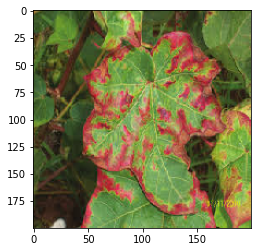

Prediction: Calcium deficiency


In [26]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(r'D:\DL\Plant Nutrient Deficiencies\CODE\Plants\Magnesium Deficiencies\gfgjfj.jfif', grayscale=False, target_size=(128,128))
show_img=image.load_img(r'D:\DL\Plant Nutrient Deficiencies\CODE\Plants\Magnesium Deficiencies\gfgjfj.jfif', grayscale=False, target_size=(200, 200))
Plants = ['Calcium deficiency','Complete nutrition', 'Iron Deficiency', 'Magnesium Deficiencies', 'Nitrogen Deficiency', 'Potassium Deficiency']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
print(custom[0])


plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',Plants[ind])
